<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

<!--BADGES-->
<a href="../slides/23.00-Cenario_Rio_Empresas.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/local-slides-darkgreen" alt="localslides" title="Local Slides"></a>
&nbsp;

<!--NAVIGATOR-->
[<- Construção de cenários: definindo as idades](22.00-Construindo_Cenarios_Distribuicao_Idades.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) 

---


# O cenário da cidade do Rio de Janeiro: rede de empresas

- Continuando a criação do cenário do Rio de Janeiro.

- Aqui, construímos a rede empresarial.

In [1]:
import datetime # date and time tools

import os, sys

import math

import random

import numpy as np
from scipy import stats

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import episiming

In [3]:
sns.set_style("darkgrid")

In [4]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 10/Jun/2020


## Distribuição populacional da cidade do Rio de Janeiro

Primeiramente, conforme feito anteriormente:

- Geramos e posicionamos as residências e os seus residentes, de acordo com os dados do [Landscan](https://landscan.ornl.gov) e com o censo residencial.

- Geramos as idades dos indivíduos.

### Carregando os dados do Landscan

Carregamos os dados populacionais por quilômetro quadrado da cidade do Rio de Janeiro obtidos do [Landscan](https://landscan.ornl.gov), mudando para 0 o valor das células com -1.

In [5]:
landscan_rio = np.load('../input/dados_rio/landscan_rio.npy').astype(int)
landscan_rio = np.maximum(landscan_rio, 0)

### Reduzindo a população

Com o objetivo de realizar testes mais rápidos, com populações menores, dividimos a população de cada bloco por um determinado fator. 

Essa divisão nos dá números em ponto flutuante, que então truncamos para a sua parte inteira. Isso reduz um pouco mais a população, mas preserva, essencialmente, a proporção entre as diferentes áreas da região.

In [6]:
pop_por_bloco = (landscan_rio/100).astype(int)
num_pop = pop_por_bloco.sum()

### Visualizando a distribuição populacional

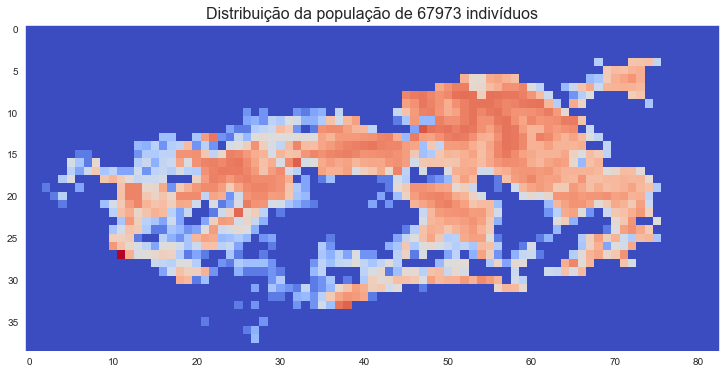

In [7]:
plt.figure(figsize=(16,6))
plt.imshow(np.log(1 + pop_por_bloco), cmap='coolwarm', interpolation='none')
#plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição da população de {num_pop} indivíduos', fontsize=16)
plt.show()

## Rede residencial

Montamos a rede residencial como antes.

O importante para a montagem da rede de empresas não é a rede residencial em si, apenas a localização dos indivíduos feita na construção da rede residencial.

### Censo residencial

Para fazer a distribuição das residências, precisamos de um "censo residencial", indicando as frações da população habitando residências de diferentes tamanhos.

Utilizaremos os seguintes valores, onde "Tamanho" é o tamanho da residência em número de residentes e "Porcentagem" é a porcentagem da população em residências do tamanho correspondente:

| Tamanho  | Porcentagem |
| --- | --- |
| 1 | 21% |
| 2 | 26% |
| 3 | 20% |
| 4 | 17% |
| 5 | 8% |
| 6 | 4% |
| 7 | 2% |
| 8 | 2% |


In [8]:
censo_residencial = np.array([.21, .26, .20, .17, .08, .04, .02, .02])
num_tam_res = len(censo_residencial) # tamanho máximo

### Visualização do censo residencial

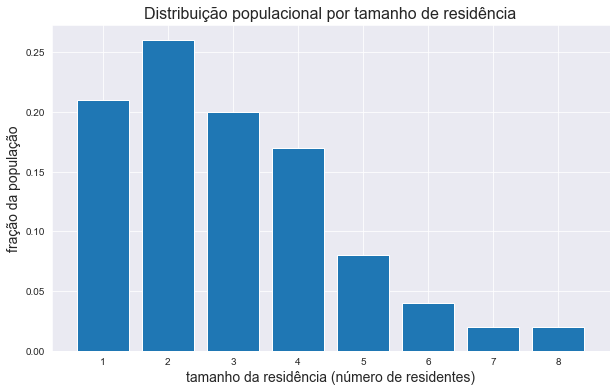

In [9]:
plt.figure(figsize=(10,6))
bar_width = 0.8
r1 = [j for j in range(1,num_tam_res+1)]
plt.bar(r1, censo_residencial, width=bar_width)
plt.xlabel('tamanho da residência (número de residentes)', fontsize=14)
plt.ylabel('fração da população', fontsize=14)
plt.title(f'Distribuição populacional por tamanho de residência', fontsize=16)
plt.show()  

### Distribuindo e alocando os indivíduos e as suas residências

Aqui, usamos a função `episiming.cenarios.aloca_residencias_e_individuos()` discutida anteriormente.

In [10]:
%%time
pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_bloco, censo_residencial)

CPU times: user 804 ms, sys: 15.7 ms, total: 820 ms
Wall time: 821 ms


### Gerando o grafo da rede residencial

In [11]:
%%time
attrib_pos_individuos = {j: pos_individuos[j] for j in range(len(pos_individuos))}

G_r = nx.random_geometric_graph(len(pop_por_bloco), 0, pos=attrib_pos_individuos)

for individuos in res_individuos:
    if len(individuos) > 1:
        G_r.add_edges_from([(i,j) for i in individuos for j in individuos if i < j])

CPU times: user 400 ms, sys: 26.3 ms, total: 426 ms
Wall time: 425 ms


### Viualização

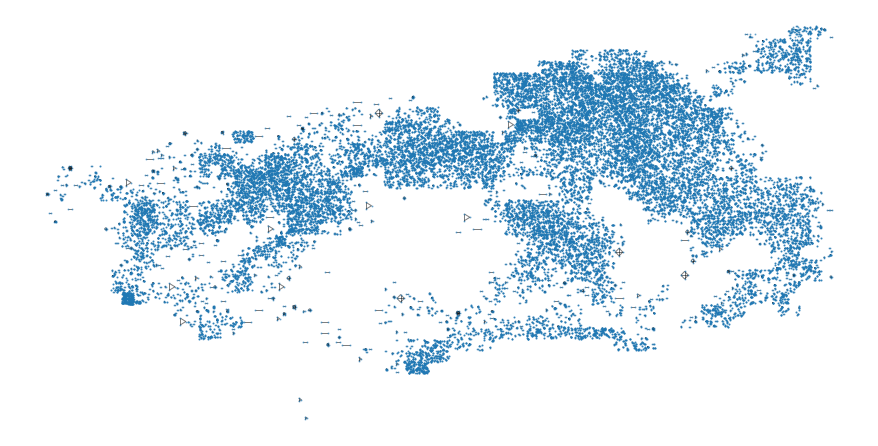

CPU times: user 1.99 s, sys: 35.4 ms, total: 2.02 s
Wall time: 2.02 s


In [12]:
%%time
plt.figure(figsize=(12,6))
nx.draw(G_r, pos=attrib_pos_individuos, node_size=1, alpha=0.5)
plt.show()

## Definindo a idade dos indivíduos

Aqui, utilizamos a função criada a partir das discussões nas últimas notas.

### Pirâmide etária

Primeiro, precisamos de tabelas para a pirâmide etária.

In [13]:
idades_grupos = np.array([0, 5, 10, 14, 18, 20, 25, 30, 40, 50, 60, 65])
idades_fracoes_grupos = np.array([0.047, 0.046, 0.043, 0.049, 0.027, 0.065, 0.067, 0.155, 0.142,
                                  0.140, 0.064, 0.155])
idade_max = 100
idades = np.arange(0,idade_max) # gera idades até < idade_max, devemos considerar se incluímos idade_max

### Interpolando/extrapolando pirâmide

A partir da tabela, obtemos frações para cada ano, com a função `obtem_idades_fracoes()`

In [14]:
idades_fracoes = episiming.cenarios.obtem_idades_fracoes(idades_grupos, idades_fracoes_grupos, idade_max)

### Gerando as idades

In [15]:
pop_idades = episiming.cenarios.gera_idades(num_pop, num_tam_res, res_individuos, idades_fracoes)

### Visualizando a pirâmide populacional obtida

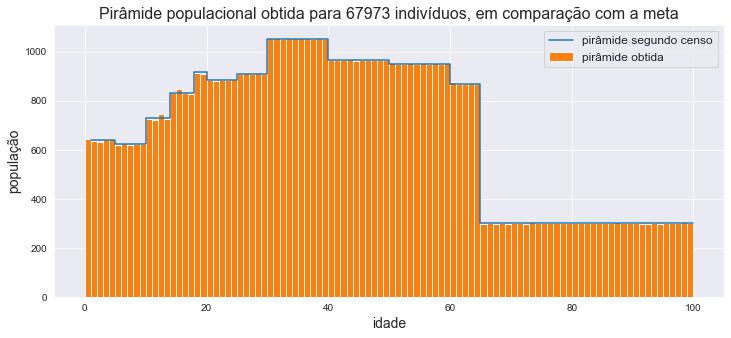

In [16]:
plt.figure(figsize=(12,5))
plt.hist(pop_idades, bins = list(range(idade_max+1)), color='tab:orange', label='pirâmide obtida')
plt.step(list(range(1, idade_max+1)), num_pop*idades_fracoes, label='pirâmide segundo censo')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title(f'Pirâmide populacional obtida para {num_pop} indivíduos, em comparação com a meta', fontsize=16)
plt.legend(fontsize=12)
plt.show()

## Rede empresarial

Na construção da rede empresarial, a ideia é fazer os seguintes passos:

- Distribuir o número de empresas por tamanho da empresa seguindo uma distribuição na forma de uma lei de potência próxima a de uma [lei de Zipf](https://en.wikipedia.org/wiki/Zipf%27s_law), com parâmetros escolhidos de acordo com a população total e um número máximo de tamanho (ou médio?).

- Distribuir as empresas pelos blocos, com pesos de acordo com a população de cada bloco.

- Alocar os indivíduos em cada empresa, levando em consideração uma determinada distância média de deslocamento.

### Dados insuficientes disponíveis no Data.Rio

Em [Instituto Pereira Passos/Data.Rio - Estabelecimentos)](http://www.data.rio/datasets/estabelecimentos-mapa-participativo?geometry=-43.859%2C-23.032%2C-42.555%2C-22.810), é possível visualizar e baixar dados com a informação de alguns estabelecimentos na cidade do Rio de Janeiro, mas são muito poucos dados.

In [17]:
estabelecimentos_rio = np.load('../input/dados_rio/estabelecimentos.npy').astype(int)

In [18]:
print(f'Total de estabelecimentos: {estabelecimentos_rio.sum()}')

Total de estabelecimentos: 263


#### Distribuição espacial desses estabelecimentos

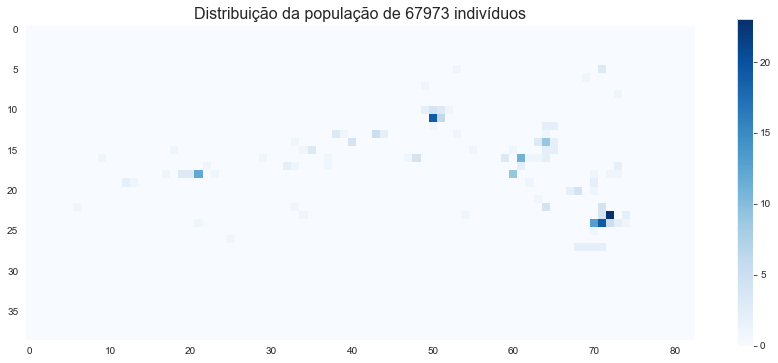

In [19]:
plt.figure(figsize=(15,6))
plt.imshow(estabelecimentos_rio, cmap='Blues', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição da população de {pop_por_bloco.sum()} indivíduos', fontsize=16)
plt.show()

### Distribuição das empresas por tamanho segundo o IBGE

Da página do IBGE com o [Cadastro Central de Empresas](https://cidades.ibge.gov.br/brasil/rj/rio-de-janeiro/pesquisa/19/0?indicador=29761), temos os seguintes dados globais para a cidade do Rio de Janeiro:

| Número de indivíduos ocupados | Número de empresas | Média de indivíduos por empresa |
| --- | --- | --- |
| 2.566.694 | 195.110 | 13,15 |

A página menciona, ainda, o número de indivíduos assalariados (2.269.964) e o número de "unidades locais" (209.237).

Uma pesquisa melhor é necessária para esclarecer os dados e, ainda, para ver se conseguimos detalhes sobre a distribuição espacial das empresas.

### Dimensionando as empresas via lei de potência

Conforme feito nos trabalhos do grupo do Imperial/Pitt, na falta de dados precisos, vamos distribuir o número de empresas por tamanho de acordo com uma lei de potência.

Vamos usar a mesma lei de potência, que é uma função com três parâmetros do tipo da [lei de Zipf](https://en.wikipedia.org/wiki/Zipf%27s_law).

#### Lei de potência do tipo Zipf com três parâmetros

- Aqui a lei de potência que eles usam para a distribuição da densidade de trabalhadores por tamanho do local de trabalho:

$$ \mathcal{P}(n > k) = f_3(k; a, c, k_\textrm{max}) 
= \frac{\displaystyle \left(\frac{\displaystyle 1 + \frac{k_\textrm{max}}{a}}{\displaystyle 1 + \frac{k}{a}}\right)^c - 1}{\displaystyle \left( 1 + \frac{k}{a}\right)^c -1}, \qquad 0 \leq k \leq k_\textrm{max}
$$

- Para a Tailândia, os parâmetros são $a = 3.26$, $c=0.97$ e $k_\textrm{max} = 2870$.

- Para os EUA e para a Grã-Bretanha, os parâmetros são $a = 5.36$, $c=1.34$ e $k_\textrm{max} = 5920$.

- Vale ressaltar que, segundo as [notas suplementares de Ferguson et al (2006)](#Referências),

    *US workplaces obey a power law distribution for the number of employees. However, as the model incorporates workplaces rather than firms, we used establishment size data... Independent data were not available for UK establishments, so US parameters were assumed.*

- Para o Rio de Janeiro ???

### População em idade ativa

- O IBGE considera a **população em idade ativa (PIA)** como sendo a população com 16 ou mais anos de idade.

In [20]:
indices = np.array(range(num_pop))
pop_pia_indices = indices[pop_idades >= 16]
num_pia = len(pop_pia_indices)
print(f'População total: {num_pop}')
print(f'População em idade ativa: {num_pia}')
print(f'Porcentagem da população em idade ativa: {100*num_pia/num_pop:.1f}%')

População total: 67973
População em idade ativa: 57060
Porcentagem da população em idade ativa: 83.9%


### População economicamente ativa

- Ainda segundo o IBGE, a **população economicamente ativa (PEA)** é composta pela população que está efetivamente trabalhando ou em busca de trabalho.

- Segundo o [censo de 2010], a população economicamente ativa do Rio de Janeiro perfazia 48,85 % da população total.

- No momento, vamos considerar a mesma proporção.

### Distribuição da população economicamente ativa por idade

- Mas essa proporção não é uniforme por idade:

    - Boa parte dos jovens com 16 e 17 anos está na escola.
    
    - Certa parte dos jovens entre 18 e 22 anos está no ensino superior.
    
    - Boa parte dos adultos com mais de 60 anos está aposentada ou, de alguma forma, fora do mercado de trabalho.
    
    - Adultos em torno de 30 anos talvez tenham uma maior taxa de de emprego.
    
- Levamos isso em consideração através de diferentes pesos no processo de seleção dos indivíduos economicamente ativos

### Dados sobre a distribuição da população economicamente ativa por idade

- Do censo de 2010 sobre a PEA do Rio de Janeiro, tiramos os seguintes dados

| Idade | PEA |
| --- | --- |
| 16 a 29 | 902115 |
| 30 a 49 | 1488515 |
| 50 a 59 | 495289 |
| 60 ou mais | 241619 |

- Como não estamos trabalhando com a população de 2010, vamos usar os dados acima como frações da distribuição da PEA atual por faixa de idade, obtendo, aproximadamente,

| Idade | PEA |
| --- | --- |
| 0 a 15 | 0% |
| 16 a 29 | 29% |
| 30 a 49 | 47% |
| 50 a 59 | 16% |
| 60 ou mais | 8% |

- O **melhor**, no entanto, seria detalharmos mais as faixas, principalmente as faixas 16 a 17 e 18 a 22.

In [21]:
num_pea_2010 = np.array([0, 902115, 1448515, 495289, 241619])
pea_fracao = 0.4885
num_pea = int(pea_fracao * num_pop)
pea_idades_faixas = np.array([0, 16, 30, 50, 60])
pea_fracoes_faixas = num_pea_2010/num_pea_2010.sum()
print(f'Conferindo PEA frações soma: {sum(pea_fracoes_faixas)}')
print(f'PEA: {num_pea}')
print(f'PEA frações da distribuição por faixa: {pea_fracoes_faixas}')
print(f'PEA distribuição por faixa: {np.around(num_pea*pea_fracoes_faixas).astype(int)}')

Conferindo PEA frações soma: 1.0
PEA: 33204
PEA frações da distribuição por faixa: [0.         0.2921794  0.46914888 0.16041552 0.0782562 ]
PEA distribuição por faixa: [    0  9702 15578  5326  2598]


### Interpolando/extrapolando frações

In [22]:
pea_fracoes = episiming.cenarios.obtem_idades_fracoes(pea_idades_faixas, pea_fracoes_faixas, idade_max=100)

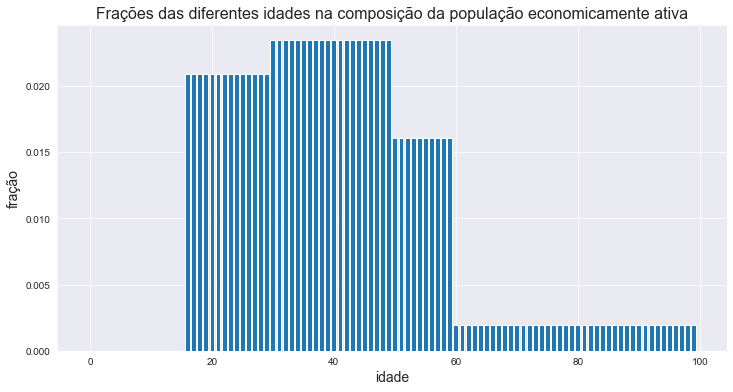

In [23]:
plt.figure(figsize=(12,6))
plt.bar(idades, pea_fracoes)
plt.xlabel('idade', fontsize=14)
plt.ylabel('fração', fontsize=14)
plt.title('Frações das diferentes idades na composição da população economicamente ativa', fontsize=16)
plt.show()

### Antigo:

In [24]:
pia_idades_grupos = np.array([0, 16, 18, 22, 25, 35, 50, 60, 80])
pia_idades_fator_grupos = np.array([0.0, 0.04, 0.10, 0.16, 0.28, 0.23, 0.14, 0.05, 0])
print(pia_idades_fator_grupos.sum())

1.0


In [25]:
pea_idades_grupos = np.array([0, 16, 18, 23, 50, 70, 100])
pea_idades_fator_grupos = np.array([0, 0.2, 0.75, 0.85, 0.75, 0.15, 0])

In [26]:
pea_idades_fator = list()
for j in range(len(pea_idades_grupos)-1):
    pea_idades_fator += (pea_idades_grupos[j+1] - pea_idades_grupos[j]) \
        * [pea_idades_fator_grupos[j]]

pea_idades_fracoes = pea_idades_fator * idades_fracoes
num_pop_emp = int(num_pop * pea_idades_fracoes.sum())

print(f'População total: {num_pop}')
print(f'População economicamente ativa: {num_pop_emp}')
print(f'Porcentagem da população que está economicamente ativa: {100*pea_idades_fracoes.sum():.1f}%')

População total: 67973
População economicamente ativa: 39114
Porcentagem da população que está economicamente ativa: 57.5%


### Visualizando a população economicamente ativa em cada ano de vida

A visualização abaixo é baseada nos dados do censo.

Mais pra frente, faremos a visualização com os dados obtidos pelo código.

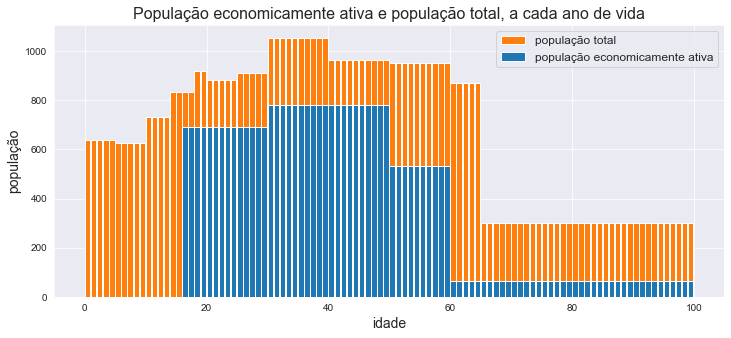

In [27]:
plt.figure(figsize=(12,5))
plt.bar(idades, num_pop*idades_fracoes,
        width=0.9, align = 'edge', color='tab:orange', label='população total')
plt.bar(idades, num_pea*pea_fracoes,
        width=0.9, align = 'edge', color='tab:blue', label='população economicamente ativa')
#plt.hist(pop_idades, bins = list(range(idade_max+1)), color='tab:blue', label='população total')
#plt.hist(pop_idades, bins = list(range(idade_max+1)), color='tab:blue', label='população total')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title(f'População economicamente ativa e população total, a cada ano de vida', fontsize=16)
plt.legend(fontsize=12)
plt.show()

### Contabilizando as empresas

#### Função de distribuição do número de empresas e trabalhadores por tamanho

In [28]:
def zipf3_acum(a, c, k_max, k):
    '''
    retorna a fração de indivíduos em empresas de tamanho maior que k.
    '''
    return (((1.0 + k_max/a)/(1.0 + k/a))**c - 1)/((1 + k_max/a)**c - 1.0)

def zipf3(a, c, k_max, k):
    '''
    retorna a fração de individuos em empresas de tamanho igual a k.
    '''
    return zipf3_acum(a, c, k_max, k-1) - zipf3_acum(a, c, k_max, k)

def zipf3e(a, c, k_max, k):
    '''
    retorna a fração de empresas de tamanho igual a k.
    '''
    return zipf3(a, c, k_max, k)/k

#### Parâmetros

In [29]:
tam_min = 2
tam_max = 1000
z3_a = 5.1
z3_c = 0.9
z3_max = 2*tam_max

#### Distribuição

In [30]:
tam_z3 = np.arange(tam_min, tam_max+1)
pop_z3 = zipf3(z3_a, z3_c, z3_max, tam_z3)
emp_z3 = zipf3e(z3_a, z3_c, z3_max, tam_z3)

In [31]:
print(zipf3_acum(z3_a, z3_c, z3_max, 0))
print(zipf3e(z3_a, z3_c, z3_max, 1))
print(zipf3(z3_a, z3_c, z3_max, 1))
print(zipf3e(z3_a, z3_c, z3_max, 2))
print(zipf3(z3_a, z3_c, z3_max, 2))

1.0
0.14952118614563326
0.14952118614563326
0.054600917069500765
0.10920183413900153


### Visualização

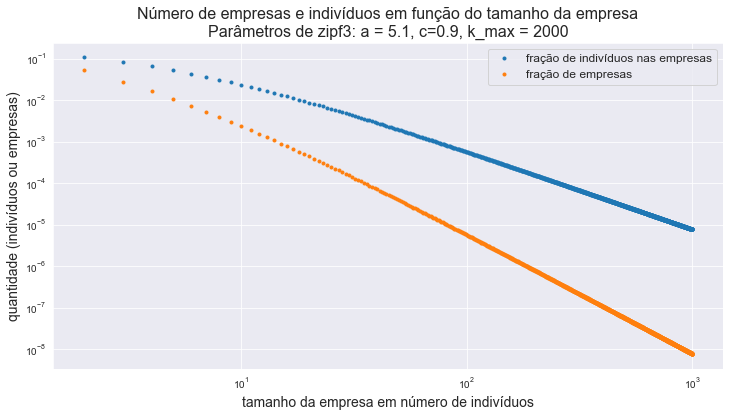

In [32]:
plt.figure(figsize=(12,6))
plt.plot(tam_z3, pop_z3, 'o', ms=3, label='fração de indivíduos nas empresas')
plt.plot(tam_z3, emp_z3, 'o', ms=3, label='fração de empresas')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12)
plt.xlabel('tamanho da empresa em número de indivíduos', fontsize=14)
plt.ylabel('quantidade (indivíduos ou empresas)', fontsize=14)
plt.title('Número de empresas e indivíduos em função do tamanho da empresa\n'
          + f'Parâmetros de zipf3: a = {z3_a}, c={z3_c}, k_max = {z3_max}', fontsize=16)
plt.show()

In [33]:
def quantifica_empresas_por_tamanho(num_pop, num_pea, tam_min, tam_max, z3_a, z3_c, verbose=False):

    emp_tam_z3 = np.arange(tam_min, 2*tam_max)
    emp_num_z3 = (num_pea*zipf3e(z3_a, z3_c, 2*tam_max, emp_tam_z3)).astype(int)
    emp_num_z3 = emp_num_z3[emp_num_z3>0]
    emp_tam_z3 = np.array(list(range(tam_min, tam_min + len(emp_num_z3))))
    emp_pop_z3 = np.array([(tam_min + k)*emp_num_z3[k] for k in range(len(emp_num_z3))])

    if not len(emp_tam_z3):
        print('Não foi possível distribuir as empresas, tente com outros parâmetros')
    elif verbose:
        print(f'Total da população: {num_pop}')
        print(f'Total da força de trabalho (PEA): {num_pea}')
        print(f'Número de tamanhos de empresas: {len(emp_num_z3)}')
        print(f'Número de empresas: {emp_num_z3.sum()}')
        print(f'Tamanhos de empresas: de {emp_tam_z3.min()} a {emp_tam_z3.max()}')
        print(f'Número de indivíduos nas empresas (PEA ocupados): {emp_pop_z3.sum()}')
        print(f'Média de indivíduos por empresa: {emp_pop_z3.sum()/emp_num_z3.sum()}')
        print('Porcentagem de indivíduos da força de trabalho nas empresas: '
              + f'{100*emp_pop_z3.sum()/num_pea:.1f}%')
        print(f'Distribuição do número de empresas por tamanho: \n{emp_num_z3}')
        print(f'Distribuição do número de indivíduos por tamanho de empresa: \n{emp_pop_z3}')
    
    return emp_tam_z3, emp_num_z3, emp_pop_z3

In [34]:
emp_tam_z3, emp_num_z3, emp_pop_z3 = \
    quantifica_empresas_por_tamanho(num_pop, num_pea, tam_min, tam_max, z3_a, z3_c,
                                   verbose=True)

Total da população: 67973
Total da força de trabalho (PEA): 33204
Número de tamanhos de empresas: 54
Número de empresas: 4815
Tamanhos de empresas: de 2 a 55
Número de indivíduos nas empresas (PEA ocupados): 24121
Média de indivíduos por empresa: 5.009553478712357
Porcentagem de indivíduos da força de trabalho nas empresas: 72.6%
Distribuição do número de empresas por tamanho: 
[1812  923  547  354  244  176  132  101   79   64   52   43   36   30
   25   22   19   16   14   13   11   10    9    8    7    6    6    5
    5    4    4    4    3    3    3    2    2    2    2    2    2    1
    1    1    1    1    1    1    1    1    1    1    1    1]
Distribuição do número de indivíduos por tamanho de empresa: 
[3624 2769 2188 1770 1464 1232 1056  909  790  704  624  559  504  450
  400  374  342  304  280  273  242  230  216  200  182  162  168  145
  150  124  128  132  102  105  108   74   76   78   80   82   84   43
   44   45   46   47   48   49   50   51   52   53   54   55]


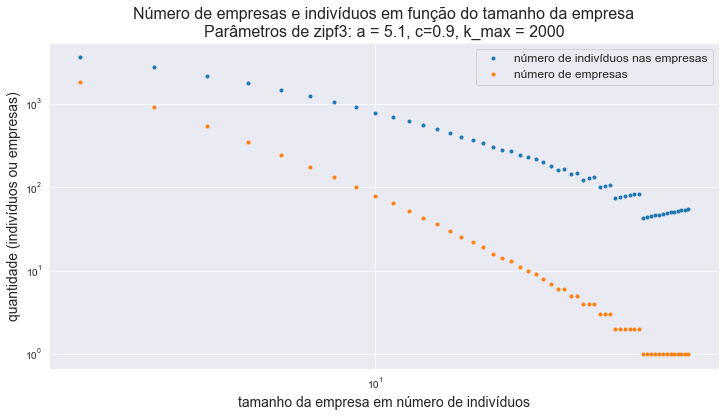

In [35]:
plt.figure(figsize=(12,6))
plt.plot(emp_tam_z3, emp_pop_z3, 'o', ms=3, label='número de indivíduos nas empresas')
plt.plot(emp_tam_z3, emp_num_z3, 'o', ms=3, label='número de empresas')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12)
plt.xlabel('tamanho da empresa em número de indivíduos', fontsize=14)
plt.ylabel('quantidade (indivíduos ou empresas)', fontsize=14)
plt.title('Número de empresas e indivíduos em função do tamanho da empresa\n'
          + f'Parâmetros de zipf3: a = {z3_a}, c={z3_c}, k_max = {z3_max}', fontsize=16)
plt.show()

In [36]:
wsc = [0, 6, 11, 21, 51, 101]
nwsc = []
for j in range(1,len(wsc)):
    nwsc.append(emp_pop_z3[wsc[j-1]:wsc[j]].sum())
nwsc.append(emp_pop_z3[wsc[j]:].sum())

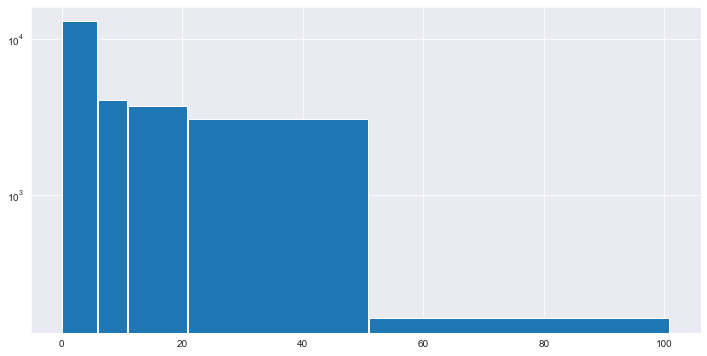

In [37]:
bar_width = [wsc[j] - wsc[j-1] - 0.2 for j in range(1,len(wsc))]
bar_width.append(emp_tam_z3[-1]-wsc[-1])
plt.figure(figsize=(12,6))
plt.bar(wsc, nwsc, bar_width, align='edge')
plt.yscale('log')
plt.show()

In [38]:
def aloca_empresas(pop_por_bloco, emp_num_z3, tam_min):
    pop_por_bloco_flat = pop_por_bloco.flatten()
    emp_loc = random.choices(list(range(len(pop_por_bloco_flat))),
                             pop_por_bloco_flat, k=emp_num_z3.sum())

    emp_por_bloco = np.zeros_like(pop_por_bloco)

    emp_bloco_pos = list()
    emp_tam = list()
    k_nivel = 0
    for k in range(len(emp_loc)):
        if k >= emp_num_z3[:k_nivel+1].sum():
            k_nivel += 1
        emp_tam.append(tam_min + k_nivel)
        loc = emp_loc[k]
        emp_bloco_pos.append((loc // 83, loc % 83))
        emp_por_bloco[loc // 83, loc % 83] += 1

    return emp_bloco_pos, emp_por_bloco, emp_tam

In [39]:
%%time
random.seed(1207)
emp_tam, emp_bloco_pos, emp_por_bloco = aloca_empresas(pop_por_bloco, emp_num_z3, tam_min)

CPU times: user 47.3 ms, sys: 1.71 ms, total: 49 ms
Wall time: 48.8 ms


In [40]:
%%time
random.seed(1207)
pop_por_bloco_flat = pop_por_bloco.flatten()
emp_loc = random.choices(list(range(len(pop_por_bloco_flat))), pop_por_bloco_flat, k=emp_num_z3.sum())

CPU times: user 11 ms, sys: 273 µs, total: 11.3 ms
Wall time: 11.2 ms


In [41]:
emp_por_bloco = np.zeros_like(pop_por_bloco)
emp_bloco_pos = list()
emp_tam = list()
k_nivel = 0
for k in range(len(emp_loc)):
    if k >= emp_num_z3[:k_nivel+1].sum():
        k_nivel += 1
    emp_tam.append(tam_min + k_nivel)
    loc = emp_loc[k]
    emp_bloco_pos.append((loc // 83, loc % 83))
    emp_por_bloco[loc // 83, loc % 83] += 1
print(f'Número de blocos alocados (com superposição, contando diferentes indivíduos): {sum(emp_tam)}')

Número de blocos alocados (com superposição, contando diferentes indivíduos): 24121


In [42]:
print(f'Total de empresas alocadas: {emp_por_bloco.sum()}')
print(f'Maior concentração de empresas: {emp_por_bloco.max()}')
print(f'(Primeiro) bloco com a maior concentração:')
print(f'({np.argmax(emp_por_bloco) // 83}, {np.argmax(emp_por_bloco) % 83})')

Total de empresas alocadas: 4815
Maior concentração de empresas: 38
(Primeiro) bloco com a maior concentração:
(27, 11)


#### Visualização espacial do número de empresas por bloco

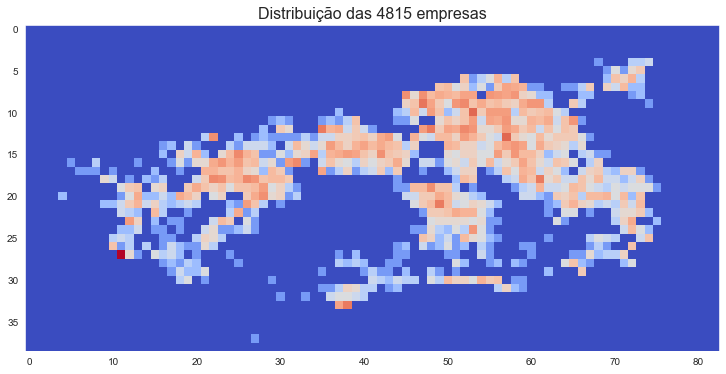

In [43]:
plt.figure(figsize=(15,6))
plt.imshow(np.log(1 + emp_por_bloco), cmap='coolwarm', interpolation='nearest')
#plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {emp_por_bloco.sum()} empresas', fontsize=16)
plt.show()

### Localização das empresas em cada bloco

- Neste primeiro momento, não vou me preocupar em detalhar isso.

- Vamos considerar a localização das empresas como sendo o centro do bloco em que cada empresa está.

- Posteriormente podemos localizá-las aleatoriamente dentro dos blocos, como feito na rede residencial, se acharmos que vale à pena.

### Distribuição da população economicamente ativa nas empresas

- Agora, para cada empresa, vamos alocar indivíduos de acordo com a distância até ela.

- Vamos fazer isso com uma função "peso", que decai com a distância.

#### Moovit

A reportagem [Moradores do RJ são os que gastam mais tempo em transporte público entre 10 regiões metropolitanas do país](https://g1.globo.com/rj/rio-de-janeiro/noticia/2020/01/15/moradores-do-rj-sao-os-que-gastam-mais-tempo-em-transporte-publico-entre-10-regioes-metropolitanas-do-brasil-mostra-aplicativo.ghtml) menciona uma média de 67 min por viagem, na região metropolitana do Rio de Janeiro. 

O que é mais interessante é a menção ao fato dos dados terem sido obtidos pelo Moovit. Isso significa que os seus dados devem ser, sim, significativos.

Devemos lembrar que, além da distância média, é interessante ajustarmos os dados de deslocamento a alguma distribuição de probabilidades.

É mencionado, pelo menos, que 36% levam entre 1 e 2 horas para chegar ao destino e 11% levam mais de 2 horas.

#### Outras informações

O artigo https://www.anpec.org.br/encontro/2014/submissao/files_I/i10-1dc14346dd67760748fefecaac00a05a.pdf dá bem mais detalhes, inclusive por bairros da cidade, baseado na análise do CENSO de 2010.

Veja, também, https://m.sebrae.com.br/Sebrae/Portal%20Sebrae/UFs/RJ/Menu%20Institucional/SEBRAE_EPG_set13_mob_urb_merc_trab_rj.pdf


### Distribuição por bloco

#### Função "peso"

In [44]:
i = np.arange(0.5, 0.5 + emp_por_bloco.shape[0])
j = np.arange(0.5, 0.5 + emp_por_bloco.shape[1])
jj, ii = np.meshgrid(j,i)
dist =  np.sqrt((jj - 25)**2 + (ii - 15)**2)
a_dist = 5
c_dist = 0.8
f_dist = lambda dist: 1/(1 + (dist/a_dist)**c_dist)

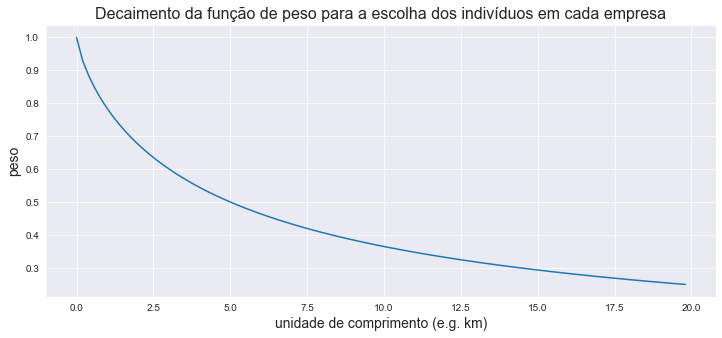

In [45]:
distancias = np.arange(0, 20, 0.2)
f_distancias = f_dist(distancias)
plt.figure(figsize=(12,5))
plt.plot(distancias, f_distancias)
plt.xlabel('unidade de comprimento (e.g. km)', fontsize=14)
plt.ylabel('peso', fontsize=14)
plt.title('Decaimento da função de peso para a escolha dos indivíduos em cada empresa', fontsize=16)
plt.show()

#### Visualização bidimensional do decaimento do peso

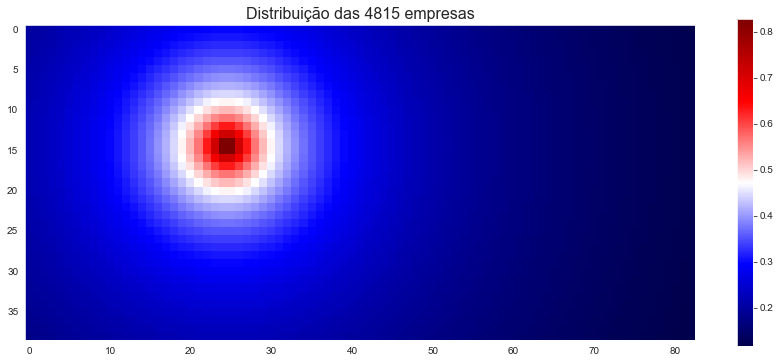

In [46]:
plt.figure(figsize=(15,6))
plt.imshow(f_dist(dist), cmap='seismic', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {emp_por_bloco.sum()} empresas', fontsize=16)
plt.show()

#### Peso em conjunto com a população por bloco

In [47]:
k_dist = f_dist(dist) * pop_por_bloco

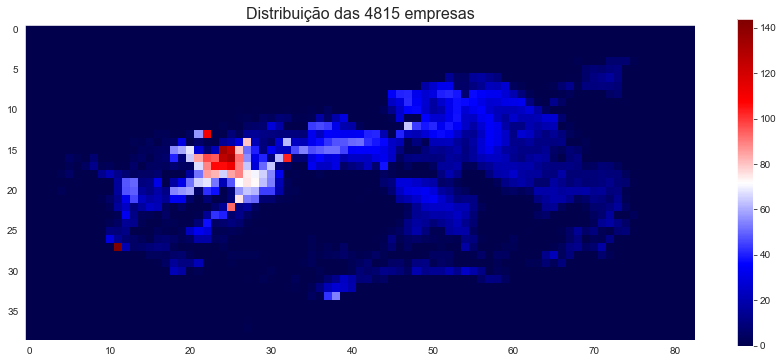

In [48]:
plt.figure(figsize=(15,6))
plt.imshow(k_dist, cmap='seismic', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {emp_num_z3.sum()} empresas', fontsize=16)
plt.show()

#### Outros parâmetros

Escolhendo um raio menor e um decaimento mais rápido:

In [49]:
a_dist = 4
c_dist = 12
f_distancias = f_dist(distancias)
k_dist = f_dist(dist) * pop_por_bloco

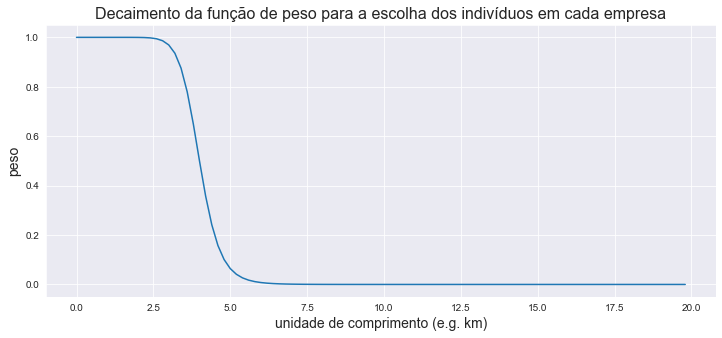

In [50]:
plt.figure(figsize=(12,5))
plt.plot(distancias, f_distancias)
plt.xlabel('unidade de comprimento (e.g. km)', fontsize=14)
plt.ylabel('peso', fontsize=14)
plt.title('Decaimento da função de peso para a escolha dos indivíduos em cada empresa', fontsize=16)
plt.show()

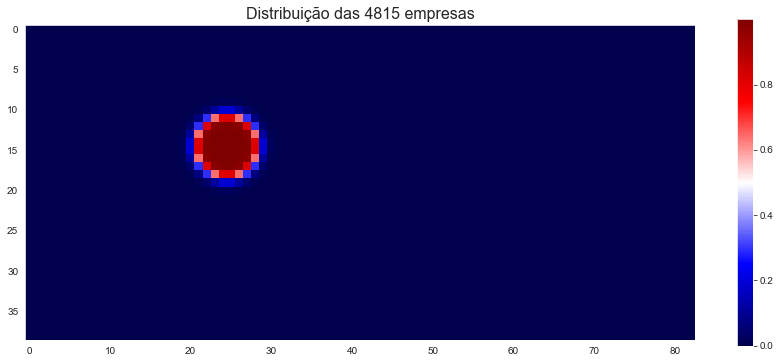

In [51]:
plt.figure(figsize=(15,6))
plt.imshow(f_dist(dist), cmap='seismic', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {emp_por_bloco.sum()} empresas', fontsize=16)
plt.show()

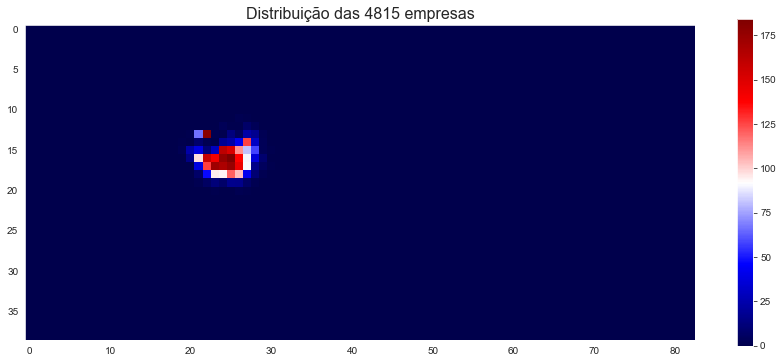

In [52]:
plt.figure(figsize=(15,6))
plt.imshow(k_dist, cmap='seismic', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {emp_num_z3.sum()} empresas', fontsize=16)
plt.show()

#### Alocando os blocos onde encontrar indivíduos para cada empresa

- Para cada empresa de tamanho `k`, sorteamos `k` blocos onde encontrar os `k` indivíduos da empresa.

- Pode haver superposição de blocos, de modo que cada empresa pode ter mais de um indivíduo no mesmo bloco.

- Os blocos são escolhidos segundo a distância até a empresa, usando a função de decaimento como peso.

In [53]:
def aloca_emp_membros_blocos(pop_por_bloco, emp_por_bloco, emp_bloco_pos, 
                             tam_min, emp_num_z3, a_dist, c_dist):
    '''
    Aloca os blocos de localização para cada indivíduo de cada empresa.
    '''
    i = np.arange(0.5, 0.5 + emp_por_bloco.shape[0])
    j = np.arange(0.5, 0.5 + emp_por_bloco.shape[1])
    jj, ii = np.meshgrid(j,i)

    emp_membros_blocos = list()

    f_dist = lambda dist: 1/(1 + (dist/a_dist)**c_dist)

    for k in range(len(emp_num_z3)):
        for j in range(emp_num_z3[k]):
            dist =  np.sqrt((jj - emp_bloco_pos[k+j][1])**2 
                            + (ii - emp_bloco_pos[k+j][0])**2)
            k_dist = f_dist(dist)*pop_por_bloco
            emp_membros_blocos.append(
                random.choices(
                    list(range(emp_por_bloco.shape[0]*emp_por_bloco.shape[1])),
                    k_dist.flatten(),
                    k = tam_min + k
                )
            )

    return emp_membros_blocos

In [54]:
%%time
random.seed(2321)
emp_membros_blocos \
    = aloca_emp_membros_blocos(pop_por_bloco, emp_por_bloco, emp_bloco_pos, tam_min, emp_num_z3, a_dist, c_dist)

print(f'Número de blocos alocados para os indivíduos: {sum([len(emp_membros_blocos[k]) for k in range(len(emp_membros_blocos))])}')  

Número de blocos alocados para os indivíduos: 24121
CPU times: user 5.7 s, sys: 29.7 ms, total: 5.73 s
Wall time: 5.77 s


#### Conferindo

In [55]:
print(len(emp_bloco_pos)) # bloco em que cada empresa está localizada
print(len(emp_tam)) # tamanho somado de cada empresa
print(len(emp_membros_blocos)) # localização linear do bloco dos indivíduos de cada empresa

4815
4815
4815


#### Alocando os indivíduos

Agora, escolhemos aleatoriamente os indivíduos para cada empresa, segundo o bloco a que pertencem.

In [56]:
def aloca_emp_individuos(num_pop, pop_idades, pop_blocos_indices, pea_fracoes,
                         emp_pop_z3, emp_tam, emp_membros_blocos):
    '''
    Aloca os indivíduos em cada empresa.
    '''
    
    indices = np.arange(len(pop_idades))
    pop_pia_indices = indices[pop_idades >= 16]    
    
    # Define os pesos de cada individuo segundo a sua idade e os pesos para cada idade
    pesos = pea_fracoes[pop_idades[pop_pia_indices]]
    pesos /= pesos.sum() # probabities must add up to 1
    pop_pia_livres = np.random.choice(pop_pia_indices,
                                      size=emp_pop_z3.sum(),
                                      replace=False,
                                      p=pesos)
    
    # Escolhe aleatoriamete um indivíduo em cada bloco alocado
    emp_membros = list()

    for j in range(len(emp_tam)):
        membros_j = list()
        for l in emp_membros_blocos[j]:
            aux = pop_pia_livres[pop_pia_livres >= pop_blocos_indices[l]]
            candidatos = aux[aux < pop_blocos_indices[l+1]]
            if len(candidatos):
                individuo = random.choice(candidatos)
                membros_j.append(individuo)
                pop_pia_livres = pop_pia_livres[pop_pia_livres != individuo]
        emp_membros.append(membros_j)

    # Alguns blocos podem não ter mais indivíduos economicamente ativos disponíveis
    # então completamos com indivíduos de outros blocos quaisquer, 
    # portanto, sem peso segundo a distância.
    for j in range(len(emp_tam)):
        faltam = emp_tam[j] - len(emp_membros[j])
        if faltam > 0:
            membros_j = list(np.random.choice(pop_pia_livres, size=faltam,
                                              replace=False))
            emp_membros[j] += membros_j
            for individuo in membros_j:
                pop_pia_livres = pop_pia_livres[pop_pia_livres != individuo]
    
    return emp_membros

In [57]:
%%time
emp_membros = aloca_emp_individuos(num_pop, pop_idades, pop_blocos_indices, pea_fracoes,
                                   emp_pop_z3, emp_tam, emp_membros_blocos)

CPU times: user 3.72 s, sys: 141 ms, total: 3.86 s
Wall time: 3.86 s


In [58]:
num_pop_emp = sum([len(emp) for emp in emp_membros])
print(f'População total: {num_pop}')
print(f'População em idade ativa: {num_pia} ({100*num_pia/num_pop:.1f}% da população total)')
print(f'População economicamente ativa: {num_pea} ({100*num_pea/num_pop:.1f}% da população total) ({100*num_pea/num_pia:.1f}% da PIA)')
print(f'Número de pessoas alocadas: {num_pop_emp} ({100*num_pop_emp/num_pop:.1f}% da população total) ({100*num_pop_emp/num_pea:.1f}% da PEA)')

População total: 67973
População em idade ativa: 57060 (83.9% da população total)
População economicamente ativa: 33204 (48.8% da população total) (58.2% da PIA)
Número de pessoas alocadas: 24121 (35.5% da população total) (72.6% da PEA)


### Lista de indivíduos por empresa

O processo abaixo nos gerou a lista `emp_membros`, em que cada membro da lista representa uma empresa e cujo valor é uma outra lista indicando todos os indivíduos alocados nessa empresa.

### Pirâmide da população economicamente ativa

Primeiro juntamos em uma lista os índices de todos os indivíduos alocados em alguma empresa

In [59]:
pop_empresas = []
for emp in emp_membros:
    pop_empresas += emp
print(f'População economicamente ativa: {len(pop_empresas)}')

População economicamente ativa: 24121


#### Visulizando a pirâmide

Agora podemos exibir a pirâmide.

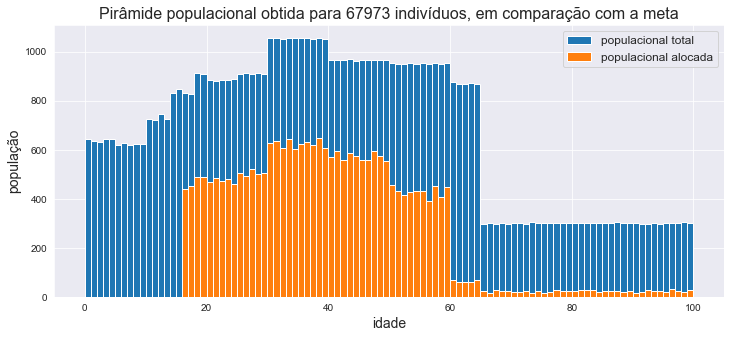

In [60]:
plt.figure(figsize=(12,5))
plt.hist(pop_idades, bins = list(range(idade_max+1)), color='tab:blue',
         label='populacional total')
#plt.hist(pop_idades[pop_pea], bins = list(range(idade_max+1)), color='tab:green',
#         label='populacional economicamente ativa')
plt.hist(pop_idades[pop_empresas], bins = list(range(idade_max+1)), color='tab:orange',
         label='populacional alocada')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title(f'Pirâmide populacional obtida para {num_pop} indivíduos, em comparação com a meta', fontsize=16)
plt.legend(fontsize=12)
plt.show()

### Gerando o grafo da rede empresarial



In [61]:
%%time
G_e = nx.random_geometric_graph(num_pop, 0, pos=attrib_pos_individuos)

for membros in emp_membros:
    if len(membros) > 1:
        G_e.add_edges_from([(i,j) for i in membros for j in membros if i < j])

CPU times: user 1.07 s, sys: 46.4 ms, total: 1.12 s
Wall time: 1.12 s


### Visualização da rede

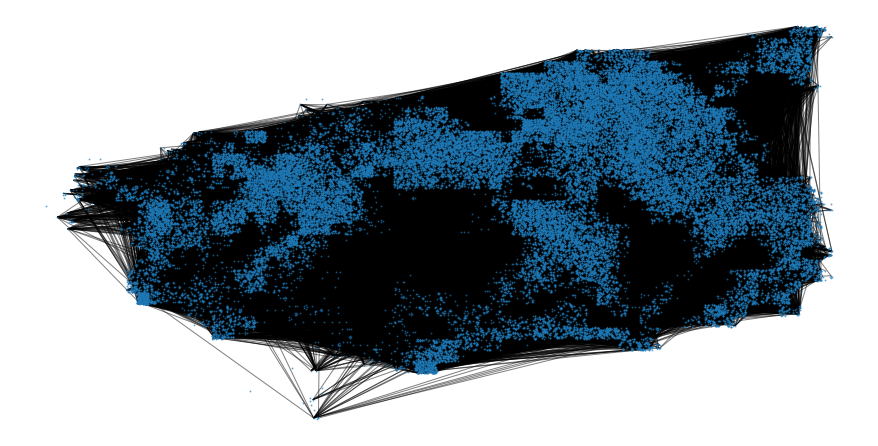

CPU times: user 9.34 s, sys: 73.2 ms, total: 9.41 s
Wall time: 9.48 s


In [62]:
%%time
plt.figure(figsize=(12,6))
nx.draw(G_e, pos=attrib_pos_individuos, node_size=1, alpha=0.5)
plt.show()

In [63]:
%%time
G_e_parte = nx.random_geometric_graph(num_pop, 0, pos=attrib_pos_individuos)

random.seed(2482)
emp_membros_10mais = [membros for membros in emp_membros if len(membros)>10]
emp_membros_parte = random.sample(emp_membros_10mais, 1)
for membros in emp_membros_parte:
    if len(membros) > 1:
        G_e_parte.add_edges_from([(i,j) for i in membros for j in membros if i < j])
for membros in emp_membros_parte:
    print(f'Empresa de tamanho: {len(membros)}')

Empresa de tamanho: 12
CPU times: user 550 ms, sys: 37.3 ms, total: 587 ms
Wall time: 601 ms


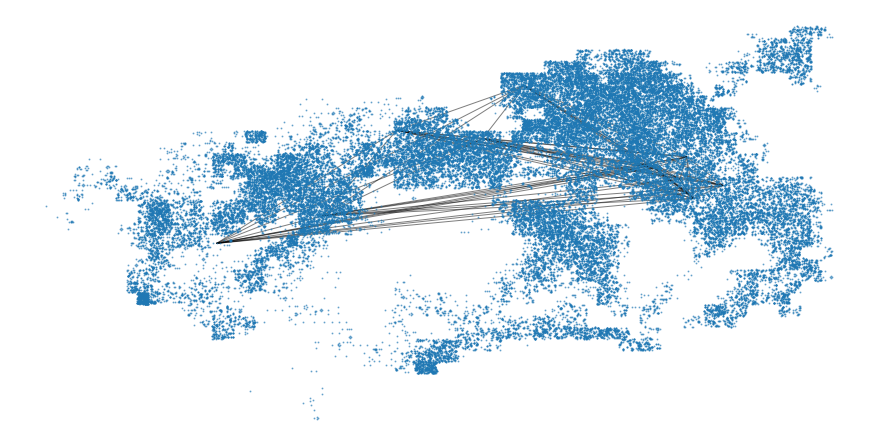

CPU times: user 783 ms, sys: 7.37 ms, total: 791 ms
Wall time: 790 ms


In [64]:
%%time
plt.figure(figsize=(12,6))
nx.draw(G_e_parte, pos=attrib_pos_individuos, node_size=1, alpha=0.5)
plt.show()

## Função de geração das empresas

- As funções acima foram incluídas no pacote de simulação.

- Uma outra função, denominada `gera_empresas()`, foi incluída, com os seguintes argumentos:

    - `pop_por_bloco`,
    
    - `pop_idades`,
    
    - `num_pea`,
    
    - `pea_fracoes`,
    
    - `tam_min`,
    
    - `tam_max`,
    
    - `z3_a`,
    
    - `z3_c`,
    
    - `a_dist`,
    
    - `c_dist`.
    
- Essa função retorna

    - `emp_bloco_pos`,
    
    - `emp_por_bloco`,
    
    - `emp_tam`,
    
    - `emp_membros`

In [65]:
def gera_empresas(pop_por_bloco, pop_idades, pop_blocos_indices,
                  num_pea, pea_fracoes, 
                  tam_min, tam_max, z3_a, z3_c, a_dist, c_dist):
    '''
    Gera as empresas, com as suas localizações e os seus indivíduos.
    '''

    num_pop = len(pop_idades)

    emp_tam_z3, emp_num_z3, emp_pop_z3 \
        = quantifica_empresas_por_tamanho(num_pop, num_pea,
                                          tam_min, tam_max,
                                          z3_a, z3_c)

    emp_bloco_pos, emp_por_bloco, emp_tam \
        = aloca_empresas(pop_por_bloco, emp_num_z3, tam_min)

    emp_membros_blocos \
        = aloca_emp_membros_blocos(pop_por_bloco, emp_por_bloco,
                                   emp_bloco_pos, tam_min, emp_num_z3,
                                   a_dist, c_dist)

    emp_membros = aloca_emp_individuos(num_pop, pop_idades,
                                       pop_blocos_indices,
                                       pea_fracoes,
                                       emp_pop_z3, emp_tam,
                                       emp_membros_blocos)

    return emp_bloco_pos, emp_por_bloco, emp_tam, emp_membros

## Testando com outros parâmetros

### Mesma população, outros parâmetros

In [66]:
tam_min = 3
tam_max = 500
z3_a = 4.5
z3_c = 1.1
a_dist = 3
c_dist = 4

In [67]:
%%time
emp_bloco_pos, emp_por_bloco, emp_tam, emp_membros \
    = gera_empresas(pop_por_bloco, pop_idades,
                    pop_blocos_indices, 
                    num_pea, pea_fracoes,
                    tam_min, tam_max, z3_a, z3_c,
                    a_dist, c_dist)

CPU times: user 6.12 s, sys: 20.7 ms, total: 6.14 s
Wall time: 6.15 s


### Montando o grafo

In [68]:
%%time
G_e = nx.random_geometric_graph(num_pop, 0, pos=attrib_pos_individuos)

for membros in emp_membros:
    if len(membros) > 1:
        G_e.add_edges_from([(i,j) for i in membros for j in membros if i < j])

CPU times: user 826 ms, sys: 35.1 ms, total: 861 ms
Wall time: 863 ms


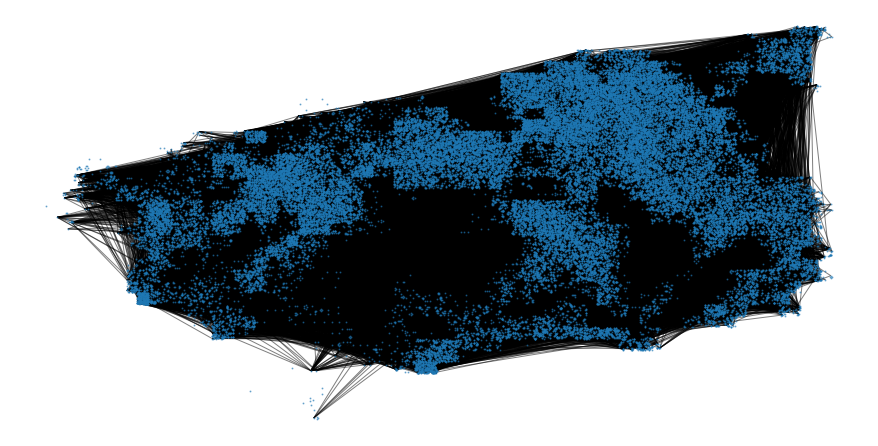

CPU times: user 7.2 s, sys: 61.2 ms, total: 7.26 s
Wall time: 7.35 s


In [69]:
%%time
plt.figure(figsize=(12,6))
nx.draw(G_e, pos=attrib_pos_individuos, node_size=1, alpha=0.5)
plt.show()

### Parte do grafo para exibição

In [70]:
%%time
G_e_parte = nx.random_geometric_graph(num_pop, 0, pos=attrib_pos_individuos)

random.seed(2482)
emp_membros_10mais = [membros for membros in emp_membros if len(membros)>10]
emp_membros_parte = random.sample(emp_membros_10mais, 1)
for membros in emp_membros_parte:
    if len(membros) > 1:
        G_e_parte.add_edges_from([(i,j) for i in membros for j in membros if i < j])
for membros in emp_membros_parte:
    print(f'Empresa de tamanho: {len(membros)}')

Empresa de tamanho: 12
CPU times: user 543 ms, sys: 41.6 ms, total: 584 ms
Wall time: 605 ms


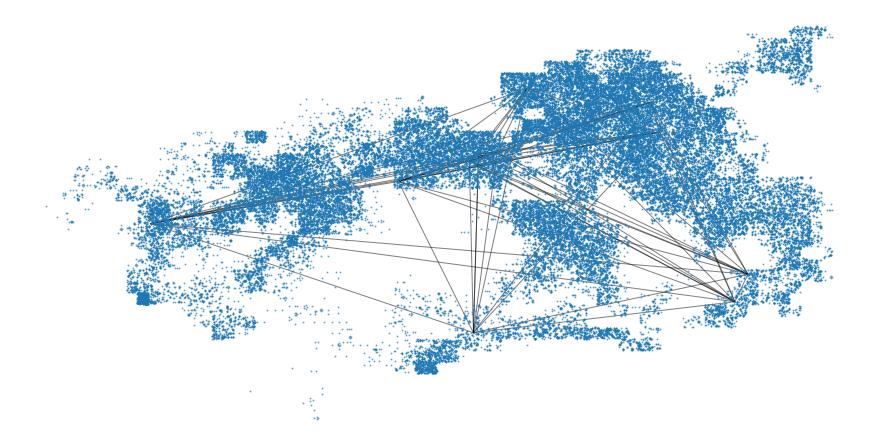

CPU times: user 787 ms, sys: 8.32 ms, total: 796 ms
Wall time: 801 ms


In [71]:
%%time
plt.figure(figsize=(12,6))
nx.draw(G_e_parte, pos=attrib_pos_individuos, node_size=1, alpha=0.5)
plt.show()

## Mudando a população e os parâmetros

Desta vez, começamos do zero, (re)definindo todas as variáveis necessárias.

In [72]:
%%time
landscan_rio = np.load('../input/dados_rio/landscan_rio.npy').astype(int)
landscan_rio = np.maximum(landscan_rio, 0)

pop_por_bloco = (landscan_rio/1000).astype(int)
num_pop = pop_por_bloco.sum()

censo_residencial = np.array([.21, .26, .20, .17, .08, .04, .02, .02])
num_tam_res = len(censo_residencial)

pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_bloco, censo_residencial)

CPU times: user 254 ms, sys: 3.42 ms, total: 257 ms
Wall time: 265 ms


In [73]:
%%time
attrib_pos_individuos = {j: pos_individuos[j] for j in range(len(pos_individuos))}

G_r = nx.random_geometric_graph(len(pop_por_bloco), 0, pos=attrib_pos_individuos)

for individuos in res_individuos:
    if len(individuos) > 1:
        G_r.add_edges_from([(i,j) for i in individuos for j in individuos if i < j])

CPU times: user 42.7 ms, sys: 7.71 ms, total: 50.4 ms
Wall time: 49.5 ms


In [74]:
idades_grupos = np.array([0, 5, 10, 14, 18, 20, 25, 30, 40, 50, 60, 65])
idades_fracoes_grupos = np.array([0.047, 0.046, 0.043, 0.049, 0.027, 0.065, 0.067, 0.155, 0.142,
                                  0.140, 0.064, 0.155])
idade_max = 100
idades = np.arange(0,idade_max) # gera idades até < idade_max, devemos considerar se incluímos idade_max

In [75]:
%%time
idades_fracoes = episiming.cenarios.obtem_idades_fracoes(idades_grupos, idades_fracoes_grupos, idade_max)

CPU times: user 77 µs, sys: 1 µs, total: 78 µs
Wall time: 83 µs


In [76]:
%%time
pop_idades = episiming.cenarios.gera_idades(num_pop, num_tam_res, res_individuos, idades_fracoes)

CPU times: user 28.8 ms, sys: 1.79 ms, total: 30.6 ms
Wall time: 29.7 ms


In [77]:
num_pea_2010 = np.array([0, 902115, 1448515, 495289, 241619])
pea_fracao = 0.4885
num_pea = int(pea_fracao * num_pop)
pea_idades_faixas = np.array([0, 16, 30, 50, 60])
pea_fracoes_faixas = num_pea_2010/num_pea_2010.sum()

In [78]:
%%time
pea_fracoes = episiming.cenarios.obtem_idades_fracoes(pea_idades_faixas, pea_fracoes_faixas, idade_max=100)

CPU times: user 91 µs, sys: 11 µs, total: 102 µs
Wall time: 129 µs


In [79]:
tam_min = 3
tam_max = 2000
z3_a = 5.2
z3_c = 1.5
a_dist = 4
c_dist = 10

In [80]:
%%time
emp_bloco_pos, emp_por_bloco, emp_tam, emp_membros \
    = episiming.cenarios.gera_empresas(pop_por_bloco, pop_idades,
                                       pop_blocos_indices,
                                       num_pea, pea_fracoes,
                                       tam_min, tam_max, z3_a, z3_c,
                                       a_dist, c_dist)

CPU times: user 389 ms, sys: 2.86 ms, total: 392 ms
Wall time: 391 ms


In [81]:
%%time
G_e = nx.random_geometric_graph(num_pop, 0, pos=attrib_pos_individuos)

for membros in emp_membros:
    if len(membros) > 1:
        G_e.add_edges_from([(i,j) for i in membros for j in membros if i < j])

CPU times: user 79 ms, sys: 8.48 ms, total: 87.4 ms
Wall time: 86.5 ms


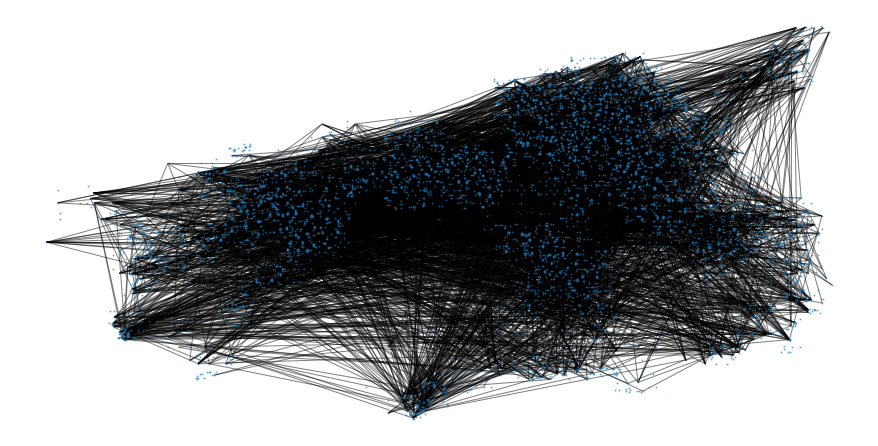

CPU times: user 712 ms, sys: 6.71 ms, total: 719 ms
Wall time: 717 ms


In [82]:
%%time
plt.figure(figsize=(12,6))
nx.draw(G_e, pos=attrib_pos_individuos, node_size=1, alpha=0.5)
plt.show()

## Referências

- [Imperial College COVID-19 Response Team (16/mar/2020), Impact of non-pharmaceutical interventions (NPIs) to reduce COVID- 19 mortality and healthcare demand, 16 de março de 2020. (Free Download)](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf)

- [Ferguson NM, Cummings DAT, Fraser C, Cajka JC, Cooley PC, Burke DS (2006). Strategies for mitigating an influenza pandemic. Nature 442 (7101), 448–52 (Free Download)](https://pubmed.ncbi.nlm.nih.gov/16642006/); veja, também, as [notas suplementares](https://www.nature.com/articles/nature04795#Sec2).

<!--NAVIGATOR-->

---
[<- Construção de cenários: definindo as idades](22.00-Construindo_Cenarios_Distribuicao_Idades.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) 